In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

Really Cool Bootstrap resources: https://bashtage.github.io/arch/bootstrap/confidence-intervals.html

### IID Bootstrap

In [2]:
# Get Sharpe Ratio
import datetime as dt

import arch.data.frenchdata
import numpy as np
import pandas as pd

ff = arch.data.frenchdata.load()

excess_market = ff.iloc[:, 0]
print(ff.describe())


def sharpe_ratio(x):
    mu, sigma = 12 * x.mean(), np.sqrt(12 * x.var())
    values = np.array([mu, sigma, mu / sigma]).squeeze()
    index = ["mu", "sigma", "SR"]
    return pd.Series(values, index=index)


params = sharpe_ratio(excess_market)
params

            Mkt-RF          SMB          HML           RF
count  1109.000000  1109.000000  1109.000000  1109.000000
mean      0.659946     0.206555     0.368864     0.274220
std       5.327524     3.191132     3.482352     0.253377
min     -29.130000   -16.870000   -13.280000    -0.060000
25%      -1.970000    -1.560000    -1.320000     0.030000
50%       1.020000     0.070000     0.140000     0.230000
75%       3.610000     1.730000     1.740000     0.430000
max      38.850000    36.700000    35.460000     1.350000


mu        7.919351
sigma    18.455084
SR        0.429115
dtype: float64

### Non-Parametric Bootstrap

In [193]:
# Note: x must be associated to the name of the functio (sharp_ratio) variable name

from arch.bootstrap import IIDBootstrap
bs = IIDBootstrap(x=excess_market)
ci = bs.conf_int(sharpe_ratio, reps=100, method="basic",
                 sampling="nonparametric")


def format_ci(params, ci):
    ci_new = pd.concat([pd.DataFrame(params).reset_index(), pd.DataFrame(ci.T)],
                       axis=1).set_index("index").rename_axis(None, axis=0)
    ci_new.columns = ["Value", "Lower Bound", "Upper Bound"]

    return ci_new


format_ci(sharpe_ratio(excess_market), ci)

,Value,Lower Bound,Upper Bound
mu,7.919351,5.150648,11.598417
sigma,18.455084,16.598829,20.146583
SR,0.429115,0.266773,0.624944


In [241]:
# Note: Same as before...
from linearmodels.iv import IV2SLS
from linearmodels.datasets import wage
import numpy as np
from statsmodels.api import add_constant
data = wage.load()
print(wage.DESCR)

"""def Instrumenta_Regression(y,x_exog,x_endog,x_instrum):
    model = IV2SLS().fit(cov_type="kernel")"""

# y,x_exog,x_endog,x_instrum = data[["lwage"]],data[["educ","age"]],data["wage"],data["exp1"]

y = np.log(data[["wage"]])
# x_exog = data[["hours","KWW","IQ",""]]
# Objective: Effect of first born in IQ, (and IQ on black)--> We use instument for birth order sibs, feduc, meduc,
# Relevance : IQ and first
data = data.dropna()
data["first_born"] = (data["brthord"] == 1).astype(int)
data["wage_z"] = (data["wage"]-data["wage"].mean())/data["wage"].std()
# y = data[["IQ"]]
# x_exog = add_constant(
#    data[["hours", "KWW", "educ", "exper", "tenure", "age", "married"]])
# x_endog = data[["first_born"]]
# x_instrum = data[["sibs", "feduc", "meduc", "black", "south", "urban"]]
# model_0 = IV2SLS(y, x_exog, x_endog, x_instrum).fit(cov_type="robust")
formula = "IQ ~ 1+hours + KWW + educ + exper + tenure + age + married+[first_born ~ sibs + feduc ]"
model_1 = IV2SLS.from_formula(formula, data).fit(cov_type="robust")


IV2SLS.from_formula(
    "wage_z ~ 1 + IQ+hours+ educ + exper + {exper**2} + tenure + age", data).fit(cov_type="robust")


M. Blackburn and D. Neumark (1992), "Unobserved Ability, Efficiency Wages, and
Interindustry Wage Differentials," Quarterly Journal of Economics 107, 1421-1436.

wage                     monthly earnings
hours                    average weekly hours
IQ                       IQ score
KWW                      knowledge of world work score
educ                     years of education
exper                    years of work experience
tenure                   years with current employer
age                      age in years
married                  =1 if married
black                    =1 if black
south                    =1 if live in south
urban                    =1 if live in SMSA
sibs                     number of siblings
brthord                  birth order
meduc                    mother's education
feduc                    father's education
lwage                    natural log of wage



OLS Estimation Summary                            
==============================================================================
Dep. Variable:                 wage_z   R-squared:                      0.1738
Estimator:                        OLS   Adj. R-squared:                 0.1650
No. Observations:                 662   F-statistic:                    136.56
Date:                Tue, Mar 26 2024   P-value (F-stat)                0.0000
Time:                        05:19:34   Distribution:                  chi2(7)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -4.3527     0.5916    -7.3580     0.0000     -5.5121     -3.1933
IQ             0.0129     0.0026     5.0313     0.0000      0.0079      0.0179
hours         -0.0075     0.0066    -1.1359     0.2560     -0.0206      0.0055
educ           0.1186     0.0216     5.4845     0.0000      0.0762      0.1609
exper          0.0493     0.0439     1.1244     0.2608     -0.0367      0.1354
exper ** 2    -0.0012     0.0019    -0.5958     0.5513     -0.0050      0.0026
tenure         0.0090     0.0076     1.1780     0.2388     -0.0060      0.0239
age            0.0390     0.0151     2.5825     0.0098      0.0094      0.0685
==============================================================================
OLSResults, id: 0x2421c3fe970

In [6]:
# Note: Same as before
import pandas as pd
import numpy as np

from arch.bootstrap import IIDBootstrap


np.random.seed(22)
x = np.random.randn(10, 2)
y = pd.DataFrame(np.random.chisquare(size=1000, df=3))
bs = IIDBootstrap(y)
ci = bs.conf_int(np.mean, reps=100, method="percentile",
                 sampling="nonparametric")

formated_ci = format_ci(y.mean(), ci)
formated_ci.index = ["mu_y"]
formated_ci

,Value,Lower Bound,Upper Bound
mu_y,2.99958,2.83574,3.176537


In [204]:
# Comparison between CI estimators
import numpy as np
from linearmodels.iv import IV2SLS
from formulaic import model_matrix
from statsmodels.api import add_constant


def ols(data):
    return IV2SLS(data["y"], add_constant(data[["x1", "x2", "x3"]]), None, None).fit(cov_type="kernel").params


np.random.seed(22)
x_sin_c = pd.DataFrame(np.random.randn(100, 3))
e = np.random.randn(100, 1)
b = np.arange(1, 4)[:, None]
y = x_sin_c.dot(b) + e
y = pd.DataFrame(y)
data = pd.concat([y, x_sin_c], axis=1)
data.columns = ["y", "x1", "x2", "x3"]
ols(data)

bs = IIDBootstrap(data)
ci = bs.conf_int(ols, reps=1000, method="percentile",
                 sampling="nonparametric")

print("Comparison: ")
print(IV2SLS(data["y"], add_constant(
    data[["x1", "x2", "x3"]]), None, None).fit(cov_type="kernel"))
print("\n\nBootstrap intervals:")
print(format_ci(ols(data), ci))

Comparison: 
                            OLS Estimation Summary                            
Dep. Variable:                      y   R-squared:                      0.9463
Estimator:                        OLS   Adj. R-squared:                 0.9447
No. Observations:                 100   F-statistic:                    2175.1
Date:                Thu, Mar 28 2024   P-value (F-stat)                0.0000
Time:                        22:39:17   Distribution:                  chi2(3)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.1466     0.0853     1.7187     0.0857     -0.0206      0.3138
x1             0.9826     0.0770     12

### Semiparametric Bootstrap
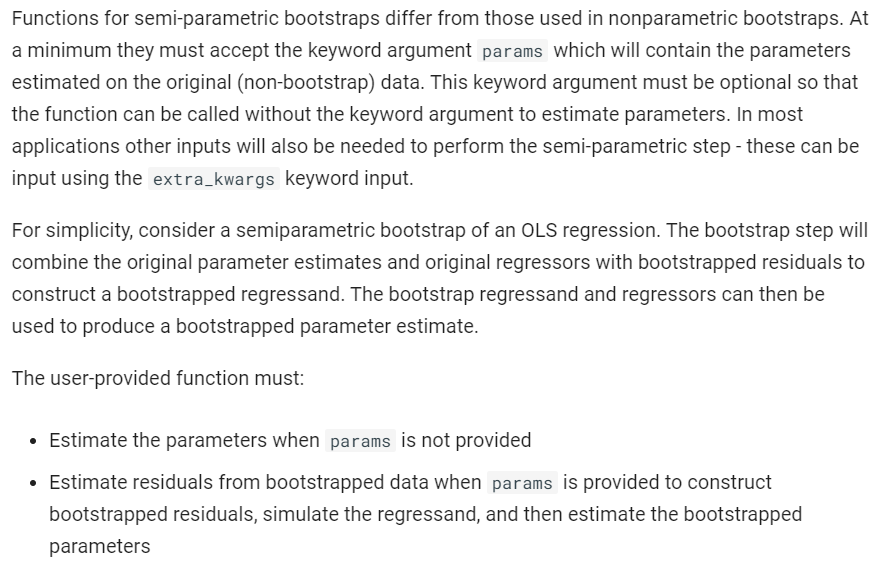
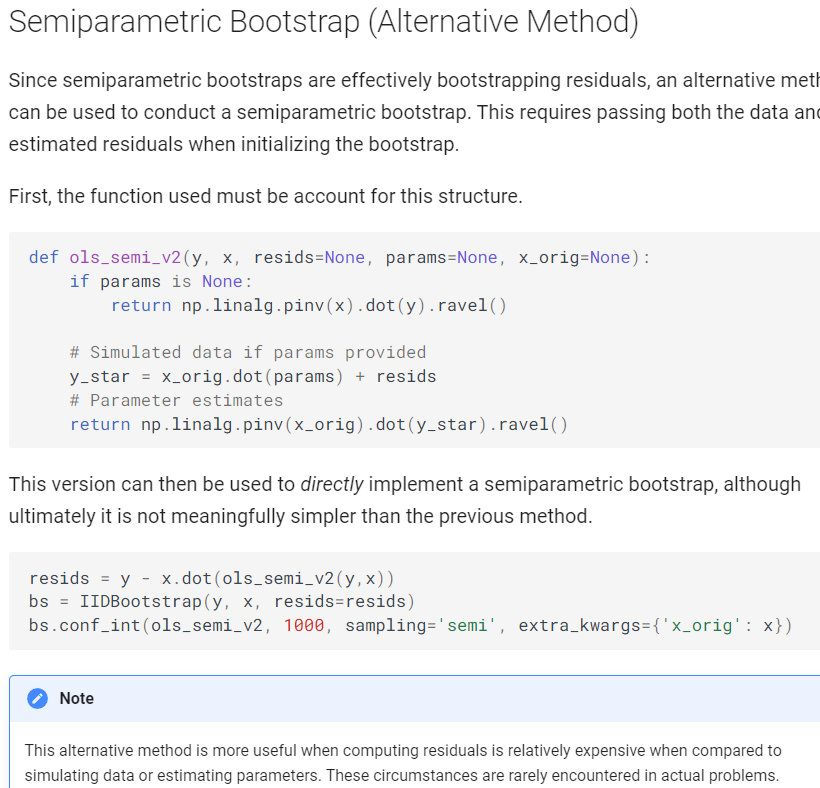

In [205]:
# Non Parametric Tecnhinque 1
from linearmodels.iv import IV2SLS
import statsmodels.api as sm
x_sin_c = pd.DataFrame(np.random.randn(100, 5))
e = np.random.randn(100, 1)
b = np.arange(1, 6)[:, None]
y = x_sin_c.dot(b) + e
y = pd.DataFrame(y)
data = sm.add_constant(pd.concat([y, x_sin_c], axis=1))
data.columns = ["const", "y", "x1", "x2", "x3", "x4", "x5"]
y = data["y"]
x = data[["const", "x1", "x2", "x3", "x4", "x5"]]


def ols(x, y, params=None, x_original_without_bootstrap=None):
    if params is None:
        return IV2SLS(y, x, None, None).fit(cov_type="kernel").params

    # When params is not None
    # Bootstrap residuals estimation(x is the bootstrap one here!)--> You get Bootstrap residuals
    resids = y - x.dot(params)
    # Now you estimate the predictions with the new residuals, and with the originaly estimated parameters
    y_star = x_original_without_bootstrap.to_numpy().dot(params) + resids
    # Bootstrap parameters estimated as each step
    return np.linalg.pinv(x_original_without_bootstrap.to_numpy()).dot(y_star).ravel()


bs = IIDBootstrap(y=y, x=x)
ci = bs.conf_int(ols, 1000, method='percentile',
                 sampling='semi',
                 # Here you must wite how you have saved in the function the "original x" variable
                 extra_kwargs={'x_original_without_bootstrap': x}
                 )
print("Comparison:")
print(IV2SLS(y, x, None, None).fit(cov_type="kernel"))
print("\n\n Non-Parametric Bootstrap intervals:")
print(format_ci(ols(x, y), ci))

Comparison:
                            OLS Estimation Summary                            
Dep. Variable:                      y   R-squared:                      0.9810
Estimator:                        OLS   Adj. R-squared:                 0.9800
No. Observations:                 100   F-statistic:                    4359.4
Date:                Thu, Mar 28 2024   P-value (F-stat)                0.0000
Time:                        22:39:46   Distribution:                  chi2(5)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0176     0.0974     0.1803     0.8569     -0.1733      0.2084
x1             0.9135     0.0944     9.6